In [ ]:
from ollama import chat
import json
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [2]:
def extract_clinical_features(patient_data):
    """
    Extract clinically relevant features from patient time-series data,
    choosing the most appropriate function for each variable.
    """
    features = {}
    
    # Static variables (use as is)
    static_vars = ['Age', 'Gender', 'Height', 'Weight']
    for var in static_vars:
        non_null = patient_data[var].dropna()
        features[var] = non_null.iloc[0] if not non_null.empty else np.nan
    
    # Define which function to use for each clinical variable
    variable_functions = {
        # Vital Signs
        'HR': 'max',                # Maximum heart rate (tachycardia)
        'SysABP': 'min',            # Minimum systolic blood pressure (hypotension)
        'DiasABP': 'min',           # Minimum diastolic blood pressure
        'MAP': 'mean',              # Mean arterial pressure (average)
        'RespRate': 'max',          # Maximum respiratory rate (distress)
        'Temp': 'max',              # Maximum temperature (fever)
        'SaO2': 'min',              # Minimum oxygen saturation (hypoxia)
        'NISysABP': 'min',          # Non-invasive systolic (minimum)
        'NIDiasABP': 'min',         # Non-invasive diastolic (minimum)
        'NIMAP': 'mean',            # Non-invasive MAP (average)
        
        # Lab Values
        'BUN': 'max',               # Maximum blood urea nitrogen (kidney)
        'Creatinine': 'max',        # Maximum creatinine (kidney)
        'Glucose': 'mean',          # Average glucose
        'HCO3': 'last',             # Last bicarbonate
        'HCT': 'min',               # Minimum hematocrit (anemia)
        'K': 'last',                # Last potassium
        'Mg': 'last',               # Last magnesium
        'Na': 'last',               # Last sodium
        'Platelets': 'min',         # Minimum platelets (bleeding risk)
        'WBC': 'max',               # Maximum white blood cells (infection)
        'Lactate': 'max',           # Maximum lactate (tissue perfusion)
        'pH': 'min',                # Minimum pH (acidosis)
        'PaCO2': 'last',            # Last CO2
        'PaO2': 'min',              # Minimum O2 (hypoxemia)
        'Albumin': 'min',           # Minimum albumin
        'ALT': 'max',               # Maximum ALT (liver)
        'AST': 'max',               # Maximum AST (liver)
        'ALP': 'max',               # Maximum alkaline phosphatase (liver)
        'Bilirubin': 'max',         # Maximum bilirubin (liver)
        'Cholesterol': 'mean',      # Average cholesterol
        'TroponinI': 'max',         # Maximum troponin I (cardiac damage)
        'TroponinT': 'max',         # Maximum troponin T (cardiac damage)
        
        # Treatment Variables
        'MechVent': 'max',          # Whether ventilation was ever used (0/1)
        'Urine': 'sum',             # Total urine output
        'FiO2': 'max',              # Maximum oxygen support needed
        'GCS': 'min'                # Minimum Glasgow Coma Scale (worst neuro status)
    }
    
    # Process each variable with its appropriate function
    for var, func in variable_functions.items():
        non_null = patient_data[var].dropna()
        
        if non_null.empty:
            features[var] = np.nan
            continue
            
        if func == 'mean':
            features[var] = non_null.mean()
        elif func == 'max':
            features[var] = non_null.max()
        elif func == 'min':
            features[var] = non_null.min()
        elif func == 'last':
            last_idx = patient_data[var].last_valid_index()
            features[var] = patient_data.loc[last_idx, var] if last_idx is not None else np.nan
        elif func == 'sum':
            features[var] = non_null.sum()
    
    return features

In [3]:
def extract_advanced_clinical_features(patient_data):
    """
    Extract advanced clinically relevant features from patient time-series data,
    including original features plus up to 15 additional time-series features.
    All features are guaranteed to have numeric values (no NaNs).
    
    Args:
        patient_data: DataFrame containing patient time-series data
        
    Returns:
        Dictionary of extracted features with no NaN values
    """

    
    # First get all the original features
    features = extract_clinical_features(patient_data)
    
    # Make sure we have a time column - if not, create one based on index
    if 'Time' not in patient_data.columns:
        # Clone the dataframe to avoid modifying the original
        ts_data = patient_data.copy()
        # Create a time column based on record index
        ts_data['Time'] = ts_data.index
    else:
        ts_data = patient_data
    
    # Define the critical vital signs for time analysis
    critical_vitals = ['HR', 'SysABP', 'RespRate', 'GCS', 'SaO2']
    
    # 1. Vital sign variability (standard deviation over time) - 5 features
    for var in critical_vitals:
        feature_name = f"{var}_variability"
        non_null = ts_data[var].dropna()
        if len(non_null) >= 3:
            features[feature_name] = non_null.std()
        else:
            # Default: 0 variability if not enough data points
            features[feature_name] = 0.0
    
    # 2. Trend features (slope of key vitals over time) - 5 features
    for var in critical_vitals:
        feature_name = f"{var}_trend"
        non_null_df = ts_data[['Time', var]].dropna()
        if len(non_null_df) >= 3:
            # Simple linear regression to get slope
            try:
                x = non_null_df['Time'].values
                y = non_null_df[var].values
                slope = np.polyfit(x, y, 1)[0]
                features[feature_name] = slope
            except:
                # Default: 0 slope (no change) if calculation fails
                features[feature_name] = 0.0
        else:
            # Default: 0 slope (no change) if not enough data points
            features[feature_name] = 0.0
    
    # 3. Shock index (HR/SBP ratio) - clinical marker of circulatory shock - 2 features
    # Initialize with default values
    features['ShockIndex_max'] = 0.0
    features['ShockIndex_trend'] = 0.0
    
    if 'HR' in ts_data.columns and 'SysABP' in ts_data.columns:
        # Get rows with valid data for both HR and SysABP
        shock_index_df = ts_data[['HR', 'SysABP']].dropna()
        # Filter out potentially dangerous division by zero or very low SBP
        shock_index_df = shock_index_df[shock_index_df['SysABP'] > 10.0]
        
        if len(shock_index_df) >= 1:
            shock_index_df['ShockIndex'] = shock_index_df['HR'] / shock_index_df['SysABP']
            features['ShockIndex_max'] = shock_index_df['ShockIndex'].max()
            
            # Calculate trend if we have enough points
            if len(shock_index_df) >= 3 and 'Time' in ts_data.columns:
                try:
                    # Merge time information
                    time_data = ts_data.loc[shock_index_df.index, 'Time']
                    if not time_data.empty:
                        x = time_data.values
                        y = shock_index_df['ShockIndex'].values
                        features['ShockIndex_trend'] = np.polyfit(x, y, 1)[0]
                except:
                    # Keep default value (0.0) if calculation fails
                    pass
    
    # 4. Additional critical composite features - 3 features
    
    # 4.1 PaO2/FiO2 ratio (for respiratory function) - 1 feature
    features['PF_ratio_min'] = 500.0  # Default to normal value (healthy is >300)
    
    if 'PaO2' in ts_data.columns and 'FiO2' in ts_data.columns:
        pf_ratio_df = ts_data[['PaO2', 'FiO2']].dropna()
        # Avoid division by zero or very low FiO2
        pf_ratio_df = pf_ratio_df[pf_ratio_df['FiO2'] > 0.2]  # FiO2 should be at least 0.21 (room air)
        
        if not pf_ratio_df.empty:
            pf_ratio_df['PF_ratio'] = pf_ratio_df['PaO2'] / pf_ratio_df['FiO2']
            features['PF_ratio_min'] = pf_ratio_df['PF_ratio'].min()
    
    # 4.2 Lactate clearance (for tissue perfusion) - 1 feature
    features['Lactate_clearance'] = 0.0  # Default to no change
    
    if 'Lactate' in ts_data.columns and 'Time' in ts_data.columns:
        lactate_df = ts_data[['Time', 'Lactate']].dropna()
        if len(lactate_df) >= 2:
            # Sort by time
            lactate_df = lactate_df.sort_values('Time')
            # Calculate lactate clearance (negative trend is good)
            try:
                x = lactate_df['Time'].values
                y = lactate_df['Lactate'].values
                features['Lactate_clearance'] = np.polyfit(x, y, 1)[0]
            except:
                # Keep default value (0.0) if calculation fails
                pass
    
    # 4.3 Glasgow Coma Scale deterioration - 1 feature
    features['GCS_deterioration'] = 0  # Default to no deterioration
    
    if 'GCS' in ts_data.columns:
        gcs_values = ts_data['GCS'].dropna()
        if len(gcs_values) >= 2:
            # Neurological deterioration = decrease in GCS of 2 or more points
            features['GCS_deterioration'] = 1 if (gcs_values.max() - gcs_values.min() >= 2) else 0
    
    # Make sure any existing NaN values from the original features are also replaced
    for key in features:
        if pd.isna(features[key]):
            # For categorical/binary features
            if key == 'Gender':
                features[key] = 'Unknown'
            elif key.endswith('_deterioration') or key == 'MechVent':
                features[key] = 0
            # For continuous features - use appropriate default values
            elif key in ['Age', 'Height', 'Weight']:
                features[key] = -1  # Indicating missing demographic
            else:
                features[key] = 0.0  # Default for other continuous variables
    
    return features

In [4]:
def process_dataset(data_path, outcome_path):
    """
    Process a dataset file to extract features and merge with outcomes
    
    Args:
        data_path: Path to the dataset file
        outcome_path: Path to the matching outcome file
        
    Returns:
        X: Feature matrix
        y: Target vector
    """
    print(f"Processing dataset: {data_path}")
    print(f"Using outcome file: {outcome_path}")
    
    # Load data
    df = pd.read_csv(data_path)
    
    # Load outcome data
    outcome_df = pd.read_csv(outcome_path)
    
    # Rename the ID column in outcome data to match patient data
    outcome_df = outcome_df.rename(columns={'RecordID': 'PatientID'})
    
    # Keep only the PatientID and In-hospital_death columns for our prediction task
    outcome_df = outcome_df[['PatientID', 'In-hospital_death']]
    
    print(f"Number of patients in dataset: {df['PatientID'].nunique()}")
    print(f"Number of patients in outcome file: {len(outcome_df)}")
    
    # Extract features for each patient
    print("Extracting features...")
    features_list = []
    for patient_id in df['PatientID'].unique():
        patient_data = df[df['PatientID'] == patient_id]
        features = extract_advanced_clinical_features(patient_data)
        features['PatientID'] = patient_id
        features_list.append(features)
    
    # Create features dataframe
    features_df = pd.DataFrame(features_list)
    
    # Merge features with outcome data
    merged_data = pd.merge(features_df, outcome_df, on='PatientID', how='inner')
    
    print(f"Number of patients with matching outcome data: {len(merged_data)}")
    
    # Separate features and target
    X = merged_data.drop(['PatientID', 'In-hospital_death'], axis=1)
    y = merged_data['In-hospital_death']
    
    # Check for any remaining NaN values (shouldn't be any since data is imputed)
    nan_counts = X.isna().sum().sum()
    if nan_counts > 0:
        print(f"Warning: {nan_counts} NaN values found in features")
    
    return X, y


In [11]:
# Define file paths
train_data_path = 'imputed_only_set-a.csv' #used scaled version only for training set
val_data_path = 'imputed_only_set-b.csv'
test_data_path = 'imputed_only_set-c.csv' 

train_outcome_path = 'Outcomes-a.txt'
val_outcome_path = 'Outcomes-b.txt'
test_outcome_path = 'Outcomes-c.txt'

# Process each dataset with its corresponding outcome file
print("\nProcessing training data...")
X_train, y_train = process_dataset(train_data_path, train_outcome_path)

print("\nProcessing validation data...")
X_val, y_val = process_dataset(val_data_path, val_outcome_path)

print("\nProcessing test data...")
X_test, y_test = process_dataset(test_data_path, test_outcome_path)

# # Check class distributions
print("\nClass distributions:")
print(f"Training: {dict(y_train.value_counts())}")
print(f"Validation: {dict(y_val.value_counts())}")
print(f"Test: {dict(y_test.value_counts())}")

# Save processed test data
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# Uncomment these lines if you also process and want to save train/val data
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)


Processing training data...
Processing dataset: imputed_only_set-a.csv
Using outcome file: Outcomes-a.txt
Number of patients in dataset: 4000
Number of patients in outcome file: 4000
Extracting features...
Number of patients with matching outcome data: 4000

Processing validation data...
Processing dataset: imputed_only_set-b.csv
Using outcome file: Outcomes-b.txt
Number of patients in dataset: 4000
Number of patients in outcome file: 4000
Extracting features...
Number of patients with matching outcome data: 4000

Processing test data...
Processing dataset: imputed_only_set-c.csv
Using outcome file: Outcomes-c.txt
Number of patients in dataset: 4000
Number of patients in outcome file: 4000
Extracting features...
Number of patients with matching outcome data: 4000

Class distributions:
Training: {0: np.int64(3446), 1: np.int64(554)}
Validation: {0: np.int64(3432), 1: np.int64(568)}
Test: {0: np.int64(3415), 1: np.int64(585)}


In [12]:
def summarize_top28_json(row):
    gcs_trend = "improving" if row["GCS_trend"] > 0 else "declining" if row["GCS_trend"] < 0 else "stable"
    saO2_trend = "decreasing" if row.get("SaO2_trend", 0) < 0 else "increasing"
    mech_vent = bool(row.get("MechVent", 0))
    hr_var = "high" if row["HR_variability"] > 10 else "moderate" if row["HR_variability"] > 5 else "low"
    resp_var = "variable" if row["RespRate_variability"] > 5 else "stable"

    patient_summary = {
        "age": int(row["Age"]),
        "weight": round(row["Weight"], 1),
        "mechanical_ventilation": mech_vent,
        "GCS": round(row["GCS"], 1),
        "GCS_trend": gcs_trend,
        "GCS_variability": round(row["GCS_variability"], 2),
        "HR": int(row["HR"]),
        "HR_variability": round(row["HR_variability"], 2),
        "RespRate_variability": round(row["RespRate_variability"], 2),
        "Glucose": round(row["Glucose"], 1),
        "HCO3": round(row["HCO3"], 2),
        "pH": round(row["pH"], 2),
        "Na": round(row["Na"], 1),
        "Mg": round(row["Mg"], 2),
        "BUN": round(row["BUN"], 1),
        "Lactate": round(row["Lactate"], 2),
        "Lactate_clearance": round(row["Lactate_clearance"], 2),
        "ALT": round(row["ALT"], 1),
        "WBC": round(row["WBC"], 1),
        "Platelets": int(row["Platelets"]),
        "PaCO2": round(row["PaCO2"], 1),
        "SaO2": int(row["SaO2"]),
        "SaO2_trend": saO2_trend,
        "FiO2": round(row["FiO2"], 2),
        "PF_ratio_min": round(row["PF_ratio_min"], 1),
        "Urine": int(row["Urine"]),
        "NIMAP": round(row["NIMAP"], 1),
        "NIDiasABP": round(row["NIDiasABP"], 1)
    }

    summary_text = (
        f"{patient_summary['age']}-year-old patient weighing {patient_summary['weight']} kg "
        f"{'on mechanical ventilation' if mech_vent else 'not on mechanical ventilation'}; "
        f"GCS {patient_summary['GCS']} ({gcs_trend}); variability {patient_summary['GCS_variability']}; "
        f"HR {patient_summary['HR']} bpm (variability: {hr_var}); "
        f"Respiratory rate variability: {resp_var}; "
        f"Glucose {patient_summary['Glucose']} mg/dL; BUN {patient_summary['BUN']} mg/dL; "
        f"Lactate {patient_summary['Lactate']} mmol/L (clearance: {patient_summary['Lactate_clearance']}%); "
        f"HCO3 {patient_summary['HCO3']} mmol/L; pH {patient_summary['pH']}; PaCO2 {patient_summary['PaCO2']} mmHg; "
        f"Na {patient_summary['Na']} mEq/L; Mg {patient_summary['Mg']} mmol/L; "
        f"WBC {patient_summary['WBC']} cells/nL; Platelets {patient_summary['Platelets']} cells/nL; "
        f"ALT {patient_summary['ALT']} IU/L; "
        f"SaO2 {patient_summary['SaO2']}% ({saO2_trend}); FiO2 {patient_summary['FiO2']}; "
        f"PF ratio min {patient_summary['PF_ratio_min']}; urine output {patient_summary['Urine']} mL; "
        f"NIMAP {patient_summary['NIMAP']} mmHg; NIDiasABP {patient_summary['NIDiasABP']} mmHg;"
    )

    patient_summary["summary_text"] = summary_text
    return patient_summary


In [13]:
# Apply to all rows in the DataFrame
summaries = [summarize_top28_json(row) for _, row in X_val.iterrows()]

# Save as JSON
import json
with open("patient_summaries_top28_val.json", "w") as f:
    json.dump(summaries, f, indent=2)

With the generated json files, we ran the `llm.sh` file on the cluster.

In [9]:
pred_df = pd.read_csv('llama_normalized_scores.csv')

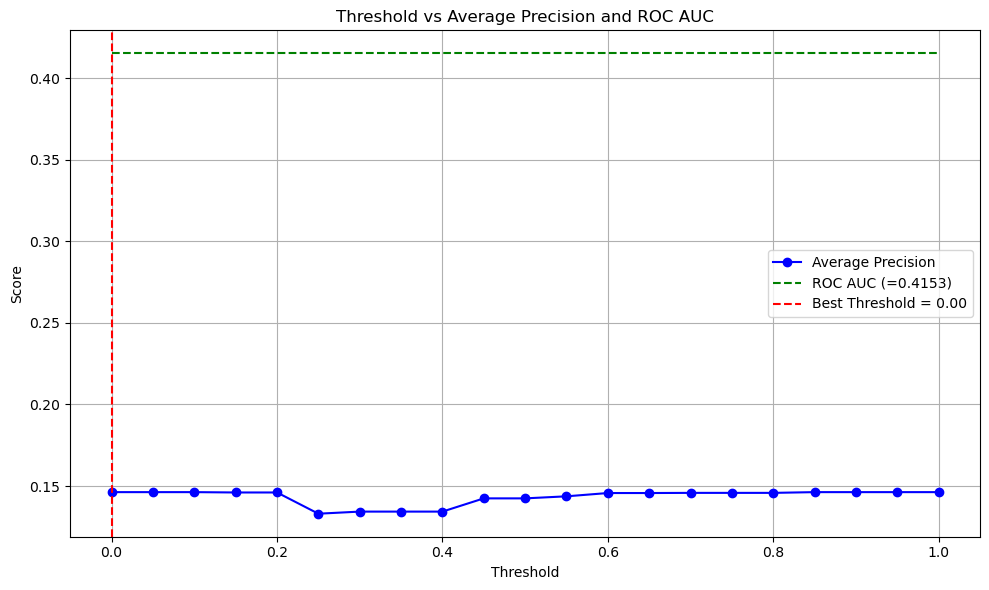

Best Threshold (by Average Precision): 0.00
Average Precision at Best Threshold: 0.1462
ROC AUC (unchanged): 0.4153


In [ ]:

# Inputs:
# pred_df: has column 'normalized_score'
# y_test: array of ground truth values

thresholds = np.arange(0.0, 1.05, 0.05)
roc_aucs = []
avg_precs = []

# Compute only once (since ROC AUC doesn’t depend on threshold)
fixed_roc_auc = roc_auc_score(y_test, pred_df["normalized_score"])

for thresh in thresholds:
    binary_pred = (pred_df["normalized_score"] >= thresh).astype(int)
    
    # ROC AUC stays constant but store it for parallel plotting
    roc_aucs.append(fixed_roc_auc)
    
    # Average precision depends on thresholded predictions
    avg_prec = average_precision_score(y_test, binary_pred)
    avg_precs.append(avg_prec)

# Find best threshold by average precision
best_idx = np.argmax(avg_precs)
best_thresh = thresholds[best_idx]

# Plotting both metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_precs, marker='o', label='Average Precision', color='blue')
plt.plot(thresholds, roc_aucs, linestyle='--', label=f'ROC AUC (={fixed_roc_auc:.4f})', color='green')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold = {best_thresh:.2f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Average Precision and ROC AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output best
print(f"Best Threshold (by Average Precision): {best_thresh:.2f}")
print(f"Average Precision at Best Threshold: {avg_precs[best_idx]:.4f}")
print(f"ROC AUC (unchanged): {fixed_roc_auc:.4f}")

In [14]:
avg_precs

[np.float64(0.14625),
 np.float64(0.14625),
 np.float64(0.14625),
 np.float64(0.1460368740689446),
 np.float64(0.1460368740689446),
 np.float64(0.1330200313465485),
 np.float64(0.13431013459729357),
 np.float64(0.13431013459729357),
 np.float64(0.13431013459729357),
 np.float64(0.1424228734228734),
 np.float64(0.1424228734228734),
 np.float64(0.1436827265261429),
 np.float64(0.14569836766148242),
 np.float64(0.14569836766148242),
 np.float64(0.14579585798816566),
 np.float64(0.14579585798816566),
 np.float64(0.14579585798816566),
 np.float64(0.14625),
 np.float64(0.14625),
 np.float64(0.14625),
 np.float64(0.14625)]

In [39]:
roc_aucs

[np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802),
 np.float64(0.4153433194428802)]